In [80]:
import numpy as np   #importing libraries
import simpy 
import queue
import random
import random as rd
import matplotlib 
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from IPython.display import Image


# rd.seed(2)

In [62]:
pip install simpy

In [96]:
global SZ,CP,RM
SZ=[]
CP=[]
RM=[]
N=1000
k=10
C=5
state=[]
#Lambda = 10
#mu = 1.5
alpha = 0.3
gamma = 0.9
#t = 0   #system clock
t1=0
t2=0
t_lambda = 0 #poisson random variable used to generate next service time
t_mu = 0  #poisson random variable used to generate next departure time
t_a=0
wait=0
R=100

transmission_time=0
l="0"
P_transmission=500
P_idle=100

episodes = 10
SHOW_EVERY = 100
STATS_EVERY=100

Q_dict=dict()
L=[]

action_list=()

In [97]:
class Packet(object):
    def __init__(self, time, id, mobileID, seeed):
        
        self.time=time                                                
        self.id=id
        self.mobileID=mobileID   
        self.size=random.randint(200,400) #seed 1 op 2, seed 2 op 
        SZ.append(round(self.size,2))
        self.cpucycle=random.uniform(100,1900)
        self.ram=random.randint(1, 32) #seed 1 op 3, seed 2 op 1, seed 3 op 4
        RM.append(round(self.ram,2))

class mobile(object): #mobile class with an ID              
    def __init__(self, ID):
        self.ID=ID
        self.pot=int(1)
        
    #generates packets and sends via out_pipe
    def packet_generator_initial(self, numPackets, env, out_pipe, task_id,send): 
        
        yield env.timeout(send)
        #print("sending task {} of mobile {} at time {}".format(task_id, self.ID, env.now))
        p=Packet(env.now, task_id, self.ID, self.pot)
        self.pot+=1
        if(self.pot==4):
                self.pot=1
        yield out_pipe.put(p)
        
    def packet_generator(self, numPackets, env, out_pipe, task_id,send,pipe4,currentpipe): 
        
        yield env.timeout(send)
        #print("sending task {} of mobile {} at time {}".format(task_id, self.ID, env.now))
        p=Packet(env.now, task_id, self.ID, self.pot)
        self.pot+=1
        if(self.pot==4):
                self.pot=1
        yield out_pipe.put(p)
        
        state=yield pipe4.get()
        yield currentpipe.put(state)



In [98]:
 def reward_generator(T,cpu,bw,cost):
    cpuU=cpu*0.5
    bwU=bw*0.3
    
    cpusla=680
    bwsla=301
    Tsla1=1.5
    Tsla2=3
    
    Ct1=0
    ct2=0
    Cp=0
    Cbw=0
    
    Nsla=3
    Gsla=3  
    Cost_sla=50
    Cg=0
    Cn=0
    Cost_n=0
    
    
    #if (G<Gsla):
        #Cg=-5*(Gsla/G)
    if (cpuU<cpusla):
        Cp=-4* (cpusla/cpuU)
    if (bwU<bwsla):
        Cbw=-4* (bwsla/bwU)
    if (T>Tsla1 and T<Tsla2):
        Ct1 = -5 * (T/Tsla1)
        rt=(Tsla1/T) + Ct1
    elif (T>=Tsla2):
        Ct2 = -6 * (T/Tsla1)
        rt=(Tsla1/T) + Ct2
    else:
        rt=(Tsla1/T)
        
    if (cost==2):
        costp=-6*cost
    else:
        costp=0
    #if (N>Nsla):
        #Cn=-5*(N/Nsla)
    #if (cost>Cost_sla):
        #Cost_n=-5*(cost/Cost_sla)
    ru=(cpuU/cpusla)+Cp+(bwU/bwsla)+Cbw
    Reward = rt + ru + costp  #Reward Function
    return Reward

In [99]:
class Fog(object):      
    def __init__(self, ID):
        self.ID=ID
        self.cpuspeed=0
        self.cpucycle=0
        self.R=0
        self.Number_queue=0
        self.lost=0
        self.transmission_time=0
        self.response_time=0
        self.server_count=0
        self.wait=0
        self.taskinqueue=0
        self.a=0
        self.time=0
        self.neighbour1=None
        self.neighbour2=None
        
        self.service_time=[]
        self.response_time_list=[]
        self.response_time_list2=[]
        self.Serverqueue=[]
        self.total_serverqueue=[]
        self.waitlist=[]
        self.energy_offloading=[]
        self.reward_list=[]
        self.state=[]
        self.observation_space_discretesize = [11, 11, 2]
        self.q_table = np.random.uniform(low=0, high=0, size=(self.observation_space_discretesize))
    
        
    def Neighbour(self,neighbour1,neighbour2):
        self.neighbour1=neighbour1
        self.neighbour2=neighbour2

    def Calculate_Q_value(self,prevoius_state,next_state,reward):

      val=Q_dict.get(((prevoius_state[0],prevoius_state[1],prevoius_state[2],prevoius_state[3],prevoius_state[4],prevoius_state[5],prevoius_state[6],prevoius_state[7],prevoius_state[8]),prevoius_state[9]))
      nxt_val_1=Q_dict.get(((next_state[0],next_state[1],next_state[2],next_state[3],next_state[4],next_state[5],next_state[6],next_state[7],next_state[8]),0))
      nxt_val_2=Q_dict.get(((next_state[0],next_state[1],next_state[2],next_state[3],next_state[4],next_state[5],next_state[6],next_state[7],next_state[8]),1))
      nxt_val_3=Q_dict.get(((next_state[0],next_state[1],next_state[2],next_state[3],next_state[4],next_state[5],next_state[6],next_state[7],next_state[8]),2))
    
#       val=Q_dict.get(((prevoius_state[0],prevoius_state[1],prevoius_state[2]),prevoius_state[3]))
#       nxt_val_1=Q_dict.get(((next_state[0],next_state[1],next_state[2]),0))
#       nxt_val_2=Q_dict.get(((next_state[0],next_state[1],next_state[2]),1))
#       nxt_val_3=Q_dict.get(((next_state[0],next_state[1],next_state[2]),2))
        
      
      if nxt_val_1==None and nxt_val_2==None and nxt_val_3==None:
          nxt_val=0
      elif nxt_val_1==None and nxt_val_2==None and nxt_val_3!=None:
          nxt_val=nxt_val_3
      elif nxt_val_1==None and nxt_val_2!=None and nxt_val_3==None:
          nxt_val=nxt_val_2
      elif nxt_val_1!=None and nxt_val_2==None and nxt_val_3==None:
          nxt_val=nxt_val_1
      elif nxt_val_1!=None and nxt_val_2!=None and nxt_val_3==None:
          if nxt_val_1>=nxt_val_2:
              nxt_val=nxt_val_1
          else:
              nxt_val=nxt_val_2
      elif nxt_val_1==None and nxt_val_2!=None and nxt_val_3!=None:
          if nxt_val_2>=nxt_val_3:
              nxt_val=nxt_val_2
          else:
              nxt_val=nxt_val_3
      elif nxt_val_1!=None and nxt_val_2==None and nxt_val_3!=None:
          if nxt_val_1>=nxt_val_3:
              nxt_val=nxt_val_1
          else:
              nxt_val=nxt_val_3
      elif nxt_val_1!=None and nxt_val_2!=None and nxt_val_3!=None:
          if nxt_val_1>=nxt_val_2 and nxt_val_1>=nxt_val_3:
              nxt_val=nxt_val_1
          elif nxt_val_2>nxt_val_1 and nxt_val_2>=nxt_val_3:
              nxt_val=nxt_val_2
          elif nxt_val_3>nxt_val_1 and nxt_val_3>nxt_val_2:
              nxt_val=nxt_val_3
      
      if val==None:
          val=0
     
                      
      target=reward+gamma*nxt_val
      
      Q_dict[((prevoius_state[0],prevoius_state[1],prevoius_state[2],prevoius_state[3],prevoius_state[4],prevoius_state[5],prevoius_state[6],prevoius_state[7],prevoius_state[8]),prevoius_state[9])]=val+alpha*(target-val)
      #Q_dict[((prevoius_state[0],prevoius_state[1],prevoius_state[2]),prevoius_state[3])]=val+alpha*(target-val)  
    
    def FOG(self, env, server, in_pipe,mobile,pipe4):
        
         msg = yield in_pipe.get()
         self.cpuspeed=random.uniform(1000,1500)
         #print("FOg",self.ID,"cPU",self.cpuspeed)
         self.R=random.uniform(900,1100)
        
         state.append([len(self.Serverqueue),len(self.neighbour1.Serverqueue),len(self.neighbour2.Serverqueue),self.cpuspeed,self.neighbour1.cpuspeed,self.neighbour2.cpuspeed,self.R,self.neighbour1.R,self.neighbour2.R,self.ID,msg.id])   # CURRENT STATE for calaculatin Q VALU
         #state.append([len(self.Serverqueue),len(self.neighbour1.Serverqueue),len(self.neighbour2.Serverqueue),self.ID,msg.id])  
        
         discrete_state=()
         discrete_state=(self.taskinqueue,self.neighbour1.taskinqueue,self.neighbour2.taskinqueue,self.cpuspeed,self.neighbour1.cpuspeed,self.neighbour2.cpuspeed,self.R,self.neighbour1.R,self.neighbour2.R)
         #discrete_state=(self.taskinqueue,self.neighbour1.taskinqueue,self.neighbour2.taskinqueue)
        
         yield pipe4.put(discrete_state) # CURRENT STATE
            
         self.transmission_time = (msg.size/self.R)
         #print("transmits task {} to need time {}".format(msg.id,transmission_time,self.ID))
         yield env.timeout(self.transmission_time)
         a=env.now
         #print("Arrived task {} at time {} at FOG {} from mobile {}".format(msg.id,a,self.ID,mobile))
         #print("server",self.server_count)
         #print("present q",self.taskinqueue)

         if self.server_count==C:
            if len(self.Serverqueue)<k:
               self.Serverqueue.append(msg)
               self.taskinqueue=len(self.Serverqueue)
               #print("queue te ase ",len(self.Serverqueue))
               #print("task ase queue te ase ",taskinqueue)
               self.Number_queue = self.Number_queue + 1
               #self.server_count=0
            else:
                 self.lost=self.lost+1
#                 cloud_transmission_time = (msg.size/R)
#                 cloud_cpuspeed=random.uniform(2000,2500)
#                 cloud_t_mu=msg.cpucycle/cloud_cpuspeed
#                 self.service_time.append(cloud_t_mu)
#                 #delay=random.uniform(3,6)
#                 delay=5
#                 self.response_time2=self.transmission_time+cloud_transmission_time+cloud_t_mu+delay
#                 self.response_time_list2.append(self.response_time2)
                
                 cost=2
                
                 r=reward_generator(10,self.cpuspeed,self.R,cost)
                 self.reward_list.append(r)
            
                 new_state=[len(self.Serverqueue),len(self.neighbour1.Serverqueue),len(self.neighbour2.Serverqueue),self.cpuspeed,self.neighbour1.cpuspeed,self.neighbour2.cpuspeed,self.R,self.neighbour1.R,self.neighbour2.R]
                 #new_state=[len(self.Serverqueue),len(self.neighbour1.Serverqueue),len(self.neighbour2.Serverqueue)]
            
                 for i in state:
                     if i[10]==msg.id:
                     #if i[4]==msg.id:
                         self.Calculate_Q_value(i,new_state,r)
                         break

                 return  

        
#          u=rd.random()
#          t_mu=-np.log(u)/mu
#          self.service_time.append(t_mu)
#          #print("service time",t_mu)
           
         t_mu=msg.cpucycle/self.cpuspeed
         self.service_time.append(t_mu)
         #print(t_mu)
         
         E = (P_transmission * self.transmission_time) + (P_idle * t_mu)
         self.energy_offloading.append(E)
         
         #print("present a queue te ase ",len(self.Serverqueue))
         #print("Fog:   Fog",self.ID,"mobile",mobile,", akhon queue te ase ",self.taskinqueue,", time",env.now)

         with server.request() as req:
             yield req
             s=env.now
             self.wait=s-a
             if len(self.Serverqueue)>0:
                 self.Serverqueue.pop(0)
             #self.total_serverqueue.append(len(self.Serverqueue))
             #print("queue",len(self.Serverqueue))
             #print("wait",self.wait)
             #print("Starting service task {} at time {} at FOG {}".format(msg.id,s,self.ID))
             #print("Waiting time of task {} at time {} at FOG {}".format(msg.id,self.wait,self.ID))
             self.waitlist.append(self.wait)
             self.response_time=self.wait+t_mu+self.transmission_time
             self.response_time_list.append(self.response_time)
             
             self.server_count=self.server_count+1
             yield env.timeout(t_mu)
             #print("Finish service task {} at time {} at FOG {}".format(msg.id,env.now,self.ID))
             self.server_count=self.server_count-1   
            
             cost=0
             r=reward_generator(self.response_time,self.cpuspeed,self.R,cost)
             self.reward_list.append(r)
             #print("r",r)
            
             new_state=[len(self.Serverqueue),len(self.neighbour1.Serverqueue),len(self.neighbour2.Serverqueue),self.cpuspeed,self.neighbour1.cpuspeed,self.neighbour2.cpuspeed,self.R,self.neighbour1.R,self.neighbour2.R]
             #new_state=[len(self.Serverqueue),len(self.neighbour1.Serverqueue),len(self.neighbour2.Serverqueue)]
            
             for i in state:
               if i[10]==msg.id:
               #if i[4]==msg.id:
                 self.Calculate_Q_value(i,new_state,r)
                 break
                

        

In [100]:
class Decision(object):
    def __init__(self, ID):
        self.ID=ID
        self.fog1_count=0
        self.fog2_count=0
        self.fog3_count=0
        self.t1=0
        self.t2=0
        self.t3=0
        self.t4=0
        self.t5=0
        self.t6=0
        self.statetime=0
        self.current=()
    def decision(self,env1,Lambda,server1,server2,server3,pipe1,pipe2,pipe3,pipe4,pipe5,pipe6,pipe7,ms1,ms2,ms3,ms4,ms5,ms6,fog1,fog2,fog3,i,statepipe,currentpipe):
        yield env1.timeout(0)

        
        #for j in range(10):
        
        if(i==0):
                 self.fog1_count=self.fog1_count+1           
                 u=rd.random()
                 t_lambda=-np.log(u)/Lambda
                 t_a=self.t1+t_lambda
                 self.t1=t_a
                 env1.process(ms1.packet_generator_initial(1, env1, pipe1, 0,t_a))
                 env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
                 #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,0,statepipe))
                    
                
        for j in range(1):
            
            u=rd.random()
            t_lambda=-np.log(u)/Lambda
            t_a=self.t1+t_lambda
            self.t1=t_a
            env1.process(ms1.packet_generator(1, env1, pipe1, i,t_a,pipe4,currentpipe))
            
            u=rd.random()
            t_lambda=-np.log(u)/Lambda
            t_a=self.t2+t_lambda
            self.t2=t_a
            env1.process(ms2.packet_generator(1, env1, pipe2, i,t_a,pipe4,currentpipe))
            
            u=rd.random()
            t_lambda=-np.log(u)/Lambda
            t_a=self.t3+t_lambda
            self.t3=t_a
            env1.process(ms3.packet_generator(1, env1, pipe3, i,t_a,pipe4,currentpipe))
            
#             u=rd.random()
#             t_lambda=-np.log(u)/Lambda
#             t_a=self.t4+t_lambda
#             self.t4=t_a
#             env1.process(ms4.packet_generator(1, env1, pipe5, i,t_a,pipe4,currentpipe))
            
#             u=rd.random()
#             t_lambda=-np.log(u)/Lambda
#             t_a=self.t5+t_lambda
#             self.t5=t_a
#             env1.process(ms5.packet_generator(1, env1, pipe6, i,t_a,pipe4,currentpipe))
             
#             u=rd.random()
#             t_lambda=-np.log(u)/Lambda
#             t_a=self.t6+t_lambda
#             self.t6=t_a
#             env1.process(ms6.packet_generator(1, env1, pipe7, i,t_a,pipe4,currentpipe))

#             current2=yield currentpipe.get()
#             #print("time, current state, i: ",env1.now,current2,i)
            
#             action1=Q_dict.get((current2,0))
#             action2=Q_dict.get((current2,1))
#             action3=Q_dict.get((current2,2))
            
#             if action1==None and action2==None and action3==None:
#               action=random.randint(0,2)
            
#             elif action1!=None and action2==None and action3==None:
#               action=0     
#             elif action1==None and action2!=None and action3==None:
#               action=1
#             elif action1==None and action2==None and action3!=None:
#               action=2
            
#             elif action1!=None and action2!=None and action3==None:
#               if action1>action2:
#                 action=0
#               else:
#                 action=1
#             elif action1==None and action2!=None and action3!=None:
#               if action2>action3:
#                 action=1
#               else:
#                 action=2
#             elif action1!=None and action2==None and action3!=None:
#               if action1>action3:
#                 action=0
#               else:
#                 action=2
                
#             elif action1!=None and action2!=None and action3!=None:
#               if action1>action2 and action1>action3:
#                 action=0
#               if action2>action1 and action2>action3:
#                 action=1
#               if action3>action1 and action3>action2:
#                 action=2
#             elif action1==action2 or action2==action3 or action1==action3:
#                 action=random.randint(0,2)
            
            action=random.randint(0,2)
            
            if(action==0):
                    
                            self.fog1_count=self.fog1_count+1
                            env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
                            #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                            # self.fog1_count=self.fog1_count+1
                            # env1.process(fog1.FOG(env1, server1, pipe2,ms2.ID,pipe4))
                            #  #env1.process(fog1.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                            
                            # self.fog1_count=self.fog1_count+1
                            # env1.process(fog1.FOG(env1, server1, pipe3,ms3.ID,pipe4))
                                                      
                            
            if(action==1):
                             self.fog2_count=self.fog2_count+1
                             env1.process(fog2.FOG(env1, server2, pipe1,ms1.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                            #  self.fog2_count=self.fog2_count+1
                            #  env1.process(fog2.FOG(env1, server2, pipe2,ms2.ID,pipe4))
                            #  #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                                
                            #  self.fog2_count=self.fog2_count+1
                            #  env1.process(fog2.FOG(env1, server2, pipe3,ms3.ID,pipe4))
                                
 
 
            if(action==2):
                             self.fog3_count=self.fog3_count+1
                             env1.process(fog3.FOG(env1, server3, pipe1,ms1.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                            #  self.fog3_count=self.fog3_count+1
                            #  env1.process(fog3.FOG(env1, server3, pipe2,ms2.ID,pipe4))
                            #  #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))           
                                
                            #  self.fog3_count=self.fog3_count+1
                            #  env1.process(fog3.FOG(env1, server3, pipe3,ms3.ID,pipe4))

####################################################1st##########################################################


            action=random.randint(0,2)
            
            if(action==0):
                    
                            # self.fog1_count=self.fog1_count+1
                            # env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
                            #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                            self.fog1_count=self.fog1_count+1
                            env1.process(fog1.FOG(env1, server1, pipe2,ms2.ID,pipe4))
                             #env1.process(fog1.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                            
                            # self.fog1_count=self.fog1_count+1
                            # env1.process(fog1.FOG(env1, server1, pipe3,ms3.ID,pipe4))
                                                      
                            
            if(action==1):
                            #  self.fog2_count=self.fog2_count+1
                            #  env1.process(fog2.FOG(env1, server2, pipe1,ms1.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                             self.fog2_count=self.fog2_count+1
                             env1.process(fog2.FOG(env1, server2, pipe2,ms2.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                                
                            #  self.fog2_count=self.fog2_count+1
                            #  env1.process(fog2.FOG(env1, server2, pipe3,ms3.ID,pipe4))
                                
 
 
            if(action==2):
                            #  self.fog3_count=self.fog3_count+1
                            #  env1.process(fog3.FOG(env1, server3, pipe1,ms1.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                             self.fog3_count=self.fog3_count+1
                             env1.process(fog3.FOG(env1, server3, pipe2,ms2.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))           
                                
                            #  self.fog3_count=self.fog3_count+1
                            #  env1.process(fog3.FOG(env1, server3, pipe3,ms3.ID,pipe4))


#######################################################2nd################################################################



            action=random.randint(0,2)
            
            if(action==0):
                    
                            # self.fog1_count=self.fog1_count+1
                            # env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
                            # #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                            # self.fog1_count=self.fog1_count+1
                            # env1.process(fog1.FOG(env1, server1, pipe2,ms2.ID,pipe4))
                            #  #env1.process(fog1.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                            
                            self.fog1_count=self.fog1_count+1
                            env1.process(fog1.FOG(env1, server1, pipe3,ms3.ID,pipe4))
                                                      
                            
            if(action==1):
                            #  self.fog2_count=self.fog2_count+1
                            #  env1.process(fog2.FOG(env1, server2, pipe1,ms1.ID,pipe4))
                            #  #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                            #  self.fog2_count=self.fog2_count+1
                            #  env1.process(fog2.FOG(env1, server2, pipe2,ms2.ID,pipe4))
                            #  #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                                
                             self.fog2_count=self.fog2_count+1
                             env1.process(fog2.FOG(env1, server2, pipe3,ms3.ID,pipe4))
                                
 
 
            if(action==2):
                            #  self.fog3_count=self.fog3_count+1
                            #  env1.process(fog3.FOG(env1, server3, pipe1,ms1.ID,pipe4))
                            #  #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                            #  self.fog3_count=self.fog3_count+1
                            #  env1.process(fog3.FOG(env1, server3, pipe2,ms2.ID,pipe4))
                            #  #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))           
                                
                             self.fog3_count=self.fog3_count+1
                             env1.process(fog3.FOG(env1, server3, pipe3,ms3.ID,pipe4))


                                
                                

In [101]:
avg_response_time=[]
avg_energy=[]

rrt=[]
random_energy=[]
for Lambda in range(1,16):
    env1 = simpy.Environment()    
    server1 = simpy.Resource(env1, capacity=C)
    server2 = simpy.Resource(env1, capacity=C)
    server3 = simpy.Resource(env1, capacity=C)
    rd.seed(2)

    pipe1 = simpy.Store(env1)
    pipe2 = simpy.Store(env1)
    pipe3 = simpy.Store(env1)
    pipe4 = simpy.Store(env1)
    pipe5 = simpy.Store(env1)
    pipe6 = simpy.Store(env1)
    pipe7 = simpy.Store(env1)
    
    statepipe = simpy.Store(env1)
    currentpipe = simpy.Store(env1)

    ms1=mobile(1)
    ms2=mobile(2)
    ms3=mobile(3)
    ms4=mobile(4)
    ms5=mobile(5)
    ms6=mobile(6)
    

    fog1 = Fog(0)
    fog2 = Fog(1)
    fog3=Fog(2)

    fog1.Neighbour(fog2,fog3)
    fog2.Neighbour(fog1,fog3)
    fog3.Neighbour(fog1,fog2)
    

    obj=Decision(1)
    #Lambda=10
    print("YO",Lambda)
    for i in range(N):
        env1.process(obj.decision(env1,Lambda,server1,server2,server3,pipe1,pipe2,pipe3,pipe4,pipe5,pipe6,pipe7,ms1,ms2,ms3,ms4,ms5,ms6,fog1,fog2,fog3,i,statepipe,currentpipe))
    env1.run()

    #print("after simulation q_table",q_table)
    #print("after simulation present state and action",action_list)

    fog1_count=obj.fog1_count
    fog2_count=obj.fog2_count
    fog3_count=obj.fog3_count
    fog1_count=fog1_count-fog1.lost
    fog2_count=fog2_count-fog2.lost
    fog3_count=fog3_count-fog3.lost

    print("lost",fog1.lost,fog2.lost,fog3.lost)
    print("present count",fog1_count,fog2_count,fog3_count)
    avgwaittime=sum(fog1.waitlist)/fog1_count
    print("FOG-1 Average queueing time:", avgwaittime)
    avgservicetime=sum(fog1.service_time)/fog1_count
    print("FOG-1 Average service time:", avgservicetime)
    avgsystemtime1=sum(fog1.response_time_list)/fog1_count
    print("MAX",max(fog1.response_time_list))
    print("FOG-1 Average response time:", avgsystemtime1)
    avgenergy1=sum(fog1.energy_offloading)/fog1_count
    #print("FOG-1 Average Energy consumption:", avgenergy1)
    
    avg_response_time.append(avgsystemtime1)
    avg_energy.append(avgenergy1)
    
    avgwaittime=sum(fog2.waitlist)/fog2_count
    print("FOG-2 Average queueing time:", avgwaittime)
    avgservicetime=sum(fog2.service_time)/fog2_count
    print("FOG-2 Average service time:", avgservicetime)
    avgsystemtime2=sum(fog2.response_time_list)/fog2_count
    print("MAX",max(fog2.response_time_list))
    print("FOG-2 Average response time:", avgsystemtime2)
    avgenergy2=sum(fog2.energy_offloading)/fog2_count
    #print("FOG-2 Average Energy consumption:", avgenergy2)
    
    avg_response_time.append(avgsystemtime2)
    avg_energy.append(avgenergy2)

    avgwaittime=sum(fog3.waitlist)/fog3_count
    print("FOG-3 Average queueing time:", avgwaittime)
    avgservicetime=sum(fog3.service_time)/fog3_count
    print("FOG-3 Average service time:", avgservicetime)
    avgsystemtime3=sum(fog3.response_time_list)/fog3_count
    print("FOG-3 Average response time:", avgsystemtime3)
    avgenergy3=sum(fog3.energy_offloading)/fog3_count
    
    avg_response_time.append(avgsystemtime3)
    avg_energy.append(avgenergy3)


#print(avg_response_time)
s=0
for i in range(0,45,3):
    s=(avg_response_time[i]+avg_response_time[i+1]+avg_response_time[i+2])/3
    s=round(s,3)
    rrt.append(s)


#plt.ylabel("Response Time")
#plt.xlabel("lambda")
#plt.show()



YO 1
lost 0 0 0
present count 1033 966 1002
FOG-1 Average queueing time: 0.0
FOG-1 Average service time: 0.8111476761248595
MAX 2.1522222491816407
FOG-1 Average response time: 1.1095613604342656
FOG-2 Average queueing time: 0.0004105827254774435
FOG-2 Average service time: 0.8252822050921181
MAX 2.18016836974614
FOG-2 Average response time: 1.1196472241773496
FOG-3 Average queueing time: 0.0008833025341292675
FOG-3 Average service time: 0.8268369486149925
FOG-3 Average response time: 1.1304573468198378
YO 2
lost 0 0 0
present count 1033 966 1002
FOG-1 Average queueing time: 0.0033051970363402873
FOG-1 Average service time: 0.8096374991840817
MAX 2.114142768003251
FOG-1 Average response time: 1.1099606413305776
FOG-2 Average queueing time: 0.012233059329366186
FOG-2 Average service time: 0.8279595285521152
MAX 2.3096294191689615
FOG-2 Average response time: 1.1333395280372585
FOG-3 Average queueing time: 0.0067852893754284955
FOG-3 Average service time: 0.8312440795246574
FOG-3 Average 

In [87]:
class Decision(object):
    def __init__(self, ID):
        self.ID=ID
        self.fog1_count=0
        self.fog2_count=0
        self.fog3_count=0
        self.t1=0
        self.t2=0
        self.t3=0
        self.t4=0
        self.t5=0
        self.t6=0
        self.statetime=0
        self.current=()
    def decision1(self,env1,Lambda,server1,server2,server3,pipe1,pipe2,pipe3,pipe4,pipe5,pipe6,pipe7,ms1,ms2,ms3,ms4,ms5,ms6,fog1,fog2,fog3,i,statepipe,currentpipe):
        yield env1.timeout(0)

        
        #for j in range(10):
        
        if(i==0):
                 self.fog1_count=self.fog1_count+1           
                 u=rd.random()
                 t_lambda=-np.log(u)/Lambda
                 t_a=self.t1+t_lambda
                 self.t1=t_a
                 env1.process(ms1.packet_generator_initial(1, env1, pipe1, 0,t_a))
                 env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
                 #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,0,statepipe))
                    
                
        for j in range(1):
            
            u=rd.random()
            t_lambda=-np.log(u)/Lambda
            t_a=self.t1+t_lambda
            self.t1=t_a
            env1.process(ms1.packet_generator(1, env1, pipe1, i,t_a,pipe4,currentpipe))
            
            u=rd.random()
            t_lambda=-np.log(u)/Lambda
            t_a=self.t2+t_lambda
            self.t2=t_a
            env1.process(ms2.packet_generator(1, env1, pipe2, i,t_a,pipe4,currentpipe))
            
            u=rd.random()
            t_lambda=-np.log(u)/Lambda
            t_a=self.t3+t_lambda
            self.t3=t_a
            env1.process(ms3.packet_generator(1, env1, pipe3, i,t_a,pipe4,currentpipe))
            
#             u=rd.random()
#             t_lambda=-np.log(u)/Lambda
#             t_a=self.t4+t_lambda
#             self.t4=t_a
#             env1.process(ms4.packet_generator(1, env1, pipe5, i,t_a,pipe4,currentpipe))
            
#             u=rd.random()
#             t_lambda=-np.log(u)/Lambda
#             t_a=self.t5+t_lambda
#             self.t5=t_a
#             env1.process(ms5.packet_generator(1, env1, pipe6, i,t_a,pipe4,currentpipe))
                         
#             u=rd.random()
#             t_lambda=-np.log(u)/Lambda
#             t_a=self.t6+t_lambda
#             self.t6=t_a
#             env1.process(ms6.packet_generator(1, env1, pipe7, i,t_a,pipe4,currentpipe))

            current2=yield currentpipe.get()
            # print("1st:",current2)
            #print("time, current state, i: ",env1.now,current2,i)
            
            action1=Q_dict.get((current2,0))
            action2=Q_dict.get((current2,1))
            action3=Q_dict.get((current2,2))
            
            if action1==None and action2==None and action3==None:
              action=random.randint(0,2)
            
            elif action1!=None and action2==None and action3==None:
              action=0     
            elif action1==None and action2!=None and action3==None:
              action=1
            elif action1==None and action2==None and action3!=None:
              action=2
            
            elif action1!=None and action2!=None and action3==None:
              if action1>action2:
                action=0
              else:
                action=1
            elif action1==None and action2!=None and action3!=None:
              if action2>action3:
                action=1
              else:
                action=2
            elif action1!=None and action2==None and action3!=None:
              if action1>action3:
                action=0
              else:
                action=2
                
            elif action1!=None and action2!=None and action3!=None:
              if action1>action2 and action1>action3:
                action=0
              if action2>action1 and action2>action3:
                action=1
              if action3>action1 and action3>action2:
                action=2
            elif action1==action2 or action2==action3 or action1==action3:
                action=random.randint(0,2)
            
            #action=random.randint(0,2)
            
            if(action==0):
                    
                            self.fog1_count=self.fog1_count+1
                            env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
                            #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                            # self.fog1_count=self.fog1_count+1
                            # env1.process(fog1.FOG(env1, server1, pipe2,ms2.ID,pipe4))
                            #env1.process(fog1.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                            
                            # self.fog1_count=self.fog1_count+1
                            # env1.process(fog1.FOG(env1, server1, pipe3,ms3.ID,pipe4))
                            

                            
            if(action==1):
                             self.fog2_count=self.fog2_count+1
                             env1.process(fog2.FOG(env1, server2, pipe1,ms1.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                            #  self.fog2_count=self.fog2_count+1
                            #  env1.process(fog2.FOG(env1, server2, pipe2,ms2.ID,pipe4))
                            #  #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                                
                            #  self.fog2_count=self.fog2_count+1
                            #  env1.process(fog2.FOG(env1, server2, pipe3,ms3.ID,pipe4))
                                

 
            if(action==2):
                             self.fog3_count=self.fog3_count+1
                             env1.process(fog3.FOG(env1, server3, pipe1,ms1.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                            #  self.fog3_count=self.fog3_count+1
                            #  env1.process(fog3.FOG(env1, server3, pipe2,ms2.ID,pipe4))
                            #  #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))           
                               
                            #  self.fog3_count=self.fog3_count+1
                            #  env1.process(fog3.FOG(env1, server3, pipe3,ms3.ID,pipe4))
###########################1st END#########################################################################################

            current2=yield currentpipe.get()
            # print("2nd:",current2)
            #print("time, current state, i: ",env1.now,current2,i)
            
            action1=Q_dict.get((current2,0))
            action2=Q_dict.get((current2,1))
            action3=Q_dict.get((current2,2))
            
            if action1==None and action2==None and action3==None:
              action=random.randint(0,2)
            
            elif action1!=None and action2==None and action3==None:
              action=0     
            elif action1==None and action2!=None and action3==None:
              action=1
            elif action1==None and action2==None and action3!=None:
              action=2
            
            elif action1!=None and action2!=None and action3==None:
              if action1>action2:
                action=0
              else:
                action=1
            elif action1==None and action2!=None and action3!=None:
              if action2>action3:
                action=1
              else:
                action=2
            elif action1!=None and action2==None and action3!=None:
              if action1>action3:
                action=0
              else:
                action=2
                
            elif action1!=None and action2!=None and action3!=None:
              if action1>action2 and action1>action3:
                action=0
              if action2>action1 and action2>action3:
                action=1
              if action3>action1 and action3>action2:
                action=2
            elif action1==action2 or action2==action3 or action1==action3:
                action=random.randint(0,2)
            
            #action=random.randint(0,2)
            
            if(action==0):
                    
                            # self.fog1_count=self.fog1_count+1
                            # env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
                            #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                            self.fog1_count=self.fog1_count+1
                            env1.process(fog1.FOG(env1, server1, pipe2,ms2.ID,pipe4))
                            #env1.process(fog1.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                            
                            # self.fog1_count=self.fog1_count+1
                            # env1.process(fog1.FOG(env1, server1, pipe3,ms3.ID,pipe4))
                            

                            
            if(action==1):
                            #  self.fog2_count=self.fog2_count+1
                            #  env1.process(fog2.FOG(env1, server2, pipe1,ms1.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                             self.fog2_count=self.fog2_count+1
                             env1.process(fog2.FOG(env1, server2, pipe2,ms2.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                                
                            #  self.fog2_count=self.fog2_count+1
                            #  env1.process(fog2.FOG(env1, server2, pipe3,ms3.ID,pipe4))
                                

 
            if(action==2):
                            #  self.fog3_count=self.fog3_count+1
                            #  env1.process(fog3.FOG(env1, server3, pipe1,ms1.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                             self.fog3_count=self.fog3_count+1
                             env1.process(fog3.FOG(env1, server3, pipe2,ms2.ID,pipe4))
                             #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))           
                               
                            #  self.fog3_count=self.fog3_count+1
                            #  env1.process(fog3.FOG(env1, server3, pipe3,ms3.ID,pipe4))

##########################################2nd END#########################################################################


            current2=yield currentpipe.get()
            # print("3rd:",current2)
            #print("time, current state, i: ",env1.now,current2,i)
            
            action1=Q_dict.get((current2,0))
            action2=Q_dict.get((current2,1))
            action3=Q_dict.get((current2,2))
            
            if action1==None and action2==None and action3==None:
              action=random.randint(0,2)
            
            elif action1!=None and action2==None and action3==None:
              action=0     
            elif action1==None and action2!=None and action3==None:
              action=1
            elif action1==None and action2==None and action3!=None:
              action=2
            
            elif action1!=None and action2!=None and action3==None:
              if action1>action2:
                action=0
              else:
                action=1
            elif action1==None and action2!=None and action3!=None:
              if action2>action3:
                action=1
              else:
                action=2
            elif action1!=None and action2==None and action3!=None:
              if action1>action3:
                action=0
              else:
                action=2
                
            elif action1!=None and action2!=None and action3!=None:
              if action1>action2 and action1>action3:
                action=0
              if action2>action1 and action2>action3:
                action=1
              if action3>action1 and action3>action2:
                action=2
            elif action1==action2 or action2==action3 or action1==action3:
                action=random.randint(0,2)
            
            #action=random.randint(0,2)
            
            if(action==0):
                    
                            # self.fog1_count=self.fog1_count+1
                            # env1.process(fog1.FOG(env1, server1, pipe1,ms1.ID,pipe4))
                            # #env1.process(fog1.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                            # self.fog1_count=self.fog1_count+1
                            # env1.process(fog1.FOG(env1, server1, pipe2,ms2.ID,pipe4))
                            # #env1.process(fog1.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                            
                            self.fog1_count=self.fog1_count+1
                            env1.process(fog1.FOG(env1, server1, pipe3,ms3.ID,pipe4))
                            

                            
            if(action==1):
                            #  self.fog2_count=self.fog2_count+1
                            #  env1.process(fog2.FOG(env1, server2, pipe1,ms1.ID,pipe4))
                            #  #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                            #  self.fog2_count=self.fog2_count+1
                            #  env1.process(fog2.FOG(env1, server2, pipe2,ms2.ID,pipe4))
                            #  #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))
                                
                             self.fog2_count=self.fog2_count+1
                             env1.process(fog2.FOG(env1, server2, pipe3,ms3.ID,pipe4))
                                

 
            if(action==2):
                            #  self.fog3_count=self.fog3_count+1
                            #  env1.process(fog3.FOG(env1, server3, pipe1,ms1.ID,pipe4))
                            #  #env1.process(fog2.nextstate(env1,ms1.ID,pipe3,pipe4,rewardpipe,action,statepipe))

                            #  self.fog3_count=self.fog3_count+1
                            #  env1.process(fog3.FOG(env1, server3, pipe2,ms2.ID,pipe4))
                            #  #env1.process(fog2.nextstate(env1,ms2.ID,pipe3,pipe4,rewardpipe,action,statepipe))           
                               
                             self.fog3_count=self.fog3_count+1
                             env1.process(fog3.FOG(env1, server3, pipe3,ms3.ID,pipe4))


                            
                            

In [88]:
avg_response_time2=[]
avg_energy2=[]

rrt2=[]
random_energy2=[]

Q_dict=dict()

for Lambda in range(1,16):
    env1 = simpy.Environment()    
    server1 = simpy.Resource(env1, capacity=C)
    server2 = simpy.Resource(env1, capacity=C)
    server3 = simpy.Resource(env1, capacity=C)
    rd.seed(2)

    pipe1 = simpy.Store(env1)
    pipe2 = simpy.Store(env1)
    pipe3 = simpy.Store(env1)
    pipe4 = simpy.Store(env1)
    pipe5 = simpy.Store(env1)
    pipe6 = simpy.Store(env1)
    pipe7 = simpy.Store(env1)
    statepipe = simpy.Store(env1)
    currentpipe = simpy.Store(env1)

    ms1=mobile(1)
    ms2=mobile(2)
    ms3=mobile(3)
    ms4=mobile(4)
    ms5=mobile(5)
    ms6=mobile(6)

    fog1 = Fog(0)
    fog2 = Fog(1)
    fog3=Fog(2)

    fog1.Neighbour(fog2,fog3)
    fog2.Neighbour(fog1,fog3)
    fog3.Neighbour(fog1,fog2)
    

    obj=Decision(1)
    #Lambda=10
    #print("YO",Lambda)
    for i in range(N):
        env1.process(obj.decision1(env1,Lambda,server1,server2,server3,pipe1,pipe2,pipe3,pipe4,pipe5,pipe6,pipe7,ms1,ms2,ms3,ms4,ms5,ms6,fog1,fog2,fog3,i,statepipe,currentpipe))
    env1.run()

    #print("after simulation q_table",q_table)
    #print("after simulation present state and action",action_list)

    fog1_count=obj.fog1_count
    fog2_count=obj.fog2_count
    fog3_count=obj.fog3_count
    fog1_count=fog1_count-fog1.lost
    fog2_count=fog2_count-fog2.lost
    fog3_count=fog3_count-fog3.lost

    #print("lost",fog1.lost,fog2.lost,fog3.lost)
    #print("present count",fog1_count,fog2_count,fog3_count)
    avgwaittime=sum(fog1.waitlist)/fog1_count
    #print("FOG-1 Average queueing time:", avgwaittime)
    avgservicetime=sum(fog1.service_time)/fog1_count
    #print("FOG-1 Average service time:", avgservicetime)
    avgsystemtime1=sum(fog1.response_time_list)/fog1_count
    #print("FOG-1 Average response time:", avgsystemtime1)
    avgenergy1=sum(fog1.energy_offloading)/fog1_count
    #print("FOG-1 Average Energy consumption:", avgenergy1)
    
    avg_response_time2.append(avgsystemtime1)
    avg_energy2.append(avgenergy1)
    

    avgwaittime=sum(fog2.waitlist)/fog2_count
    #print("FOG-2 Average queueing time:", avgwaittime)
    avgservicetime=sum(fog2.service_time)/fog2_count
    #print("FOG-2 Average service time:", avgservicetime)
    avgsystemtime2=sum(fog2.response_time_list)/fog2_count
    #print("FOG-2 Average response time:", avgsystemtime2)
    avgenergy2=sum(fog2.energy_offloading)/fog2_count
    #print("FOG-2 Average Energy consumption:", avgenergy2)
    
    avg_response_time2.append(avgsystemtime2)
    avg_energy2.append(avgenergy2)

    avgwaittime=sum(fog3.waitlist)/fog3_count
    #print("FOG-3 Average queueing time:", avgwaittime)
    avgservicetime=sum(fog3.service_time)/fog3_count
    #print("FOG-3 Average service time:", avgservicetime)
    avgsystemtime3=sum(fog3.response_time_list)/fog3_count
    #print("FOG-3 Average response time:", avgsystemtime3)
    avgenergy3=sum(fog3.energy_offloading)/fog3_count
    
    avg_response_time2.append(avgsystemtime3)
    avg_energy2.append(avgenergy3)

#print(avg_response_time2)
#print(Q_dict)
s=0
for i in range(0,45,3):
    s=(avg_response_time2[i]+avg_response_time2[i+1]+avg_response_time2[i+2])/3
    s=round(s,3)
    rrt2.append(s)



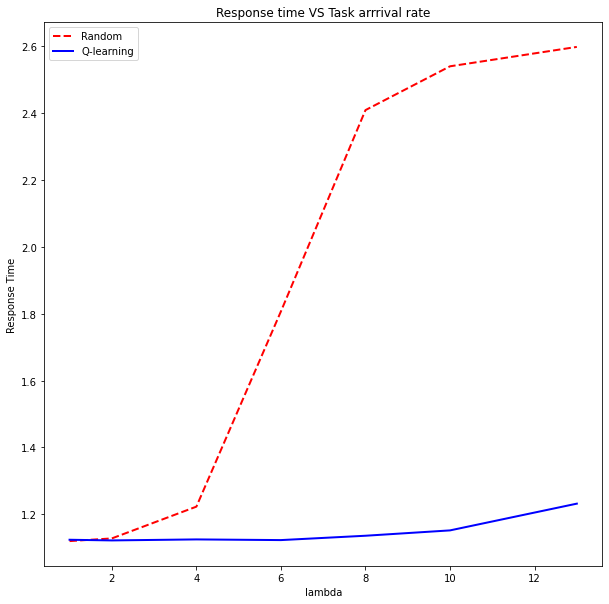

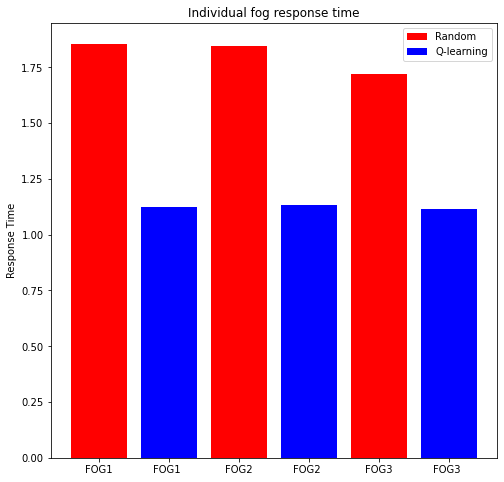

In [89]:
# print(rrt)
# print(rrt2)

#lamda1=[1,2,4,6,8,10,11] # 10,11,12 bad
#lamda2=[1,2,4,6,8,10,11]

lamda1=[1,2,4,6,8,10,13] # 10,11,12 bad
lamda2=[1,2,4,6,8,10,13]

#time1=[ rrt[0],rrt[1],rrt[3],rrt[5],rrt[7],rrt[9],rrt[10] ]
#time2=[ rrt2[0],rrt2[1],rrt2[3],rrt2[5],rrt2[7],rrt2[9],rrt2[10] ]

time1=[ rrt[0],rrt[1],rrt[3],rrt[5],rrt[7],rrt[9],rrt[12] ]
time2=[ rrt2[0],rrt2[1],rrt2[3],rrt2[5],rrt2[7],rrt2[9],rrt2[12] ]

plt.rcParams['figure.figsize'] = (10,10)

l1=plt.plot(lamda1,time1,linewidth=2,color='red',linestyle='dashed',label='Random')
l2=plt.plot(lamda2,time2,linewidth=2,color='blue',label='Q-learning')

#plt.yticks([1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25])
#plt.yticks([1,1.5,2,2.5,3,3.5,4,5])
#plt.yticks([1,2,3,4,5,6])
#plt.yticks([1,1.10,1.20,1.30,1.40,1.50,1.60,1.70,1.80,1.90,2,2.10,2.20,2.30,2.40,2.50,2.60,2.70,2.80,2.90,3,3.10,3.20,3.30,3.40,3.50,3.60,3.70,3.80,3.90,4,4.10])
plt.ylabel("Response Time")
plt.xlabel("lambda")
plt.title("Response time VS Task arrrival rate")
plt.legend()
#plt.savefig('G:/THESIS/Figuress/c5fig1.png')
#plt.figure(figsize=(4,2))

plt.show()

plt.rcParams['figure.figsize'] = (8,8)

plt.bar(['FOG1'],[avg_response_time[15]], color = ['red'],label='Random')
plt.bar(['FOG1 '],[avg_response_time2[15]], color = ['blue'],label='Q-learning')
plt.bar(['FOG2'],[avg_response_time[16]], color = ['red'])
plt.bar(['FOG2 '],[avg_response_time2[16]], color = ['blue'])
plt.bar(['FOG3'],[avg_response_time[17]], color = ['red'])
plt.bar(['FOG3 '],[avg_response_time2[17]], color = ['blue'])

# plt.bar(['FOG1'],[avg_response_time[18]], color = ['red'],label='Random')
# plt.bar(['FOG1 '],[avg_response_time2[18]], color = ['blue'],label='Q-learning')
# plt.bar(['FOG2'],[avg_response_time[19]], color = ['red'])
# plt.bar(['FOG2 '],[avg_response_time2[19]], color = ['blue'])
# plt.bar(['FOG3'],[avg_response_time[20]], color = ['red'])
# plt.bar(['FOG3 '],[avg_response_time2[20]], color = ['blue'])

# plt.bar(['FOG1'],[avg_response_time[21]], color = ['red'],label='Random')
# plt.bar(['FOG1 '],[avg_response_time2[21]], color = ['blue'],label='Q-learning')
# plt.bar(['FOG2'],[avg_response_time[22]], color = ['red'])
# plt.bar(['FOG2 '],[avg_response_time2[22]], color = ['blue'])
# plt.bar(['FOG3'],[avg_response_time[23]], color = ['red'])
# plt.bar(['FOG3 '],[avg_response_time2[23]], color = ['blue'])



#plt.yticks([0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5])
#plt.yticks([0,1,2,3,4,5,6])
#plt.yticks([1,1.10,1.20,1.30,1.40,1.50,1.60,1.70,1.80,1.90,2,2.10,2.20,2.30,2.40,2.50,2.60,2.70,2.80,2.90,3,3.10,3.20,3.30,3.40,3.50,3.60,3.70,3.80,3.90,4,4.10])
plt.ylabel("Response Time")
plt.title("Individual fog response time")
plt.legend()
#plt.savefig('G:/THESIS/Figuress/c5l6fig2.png')

plt.show()

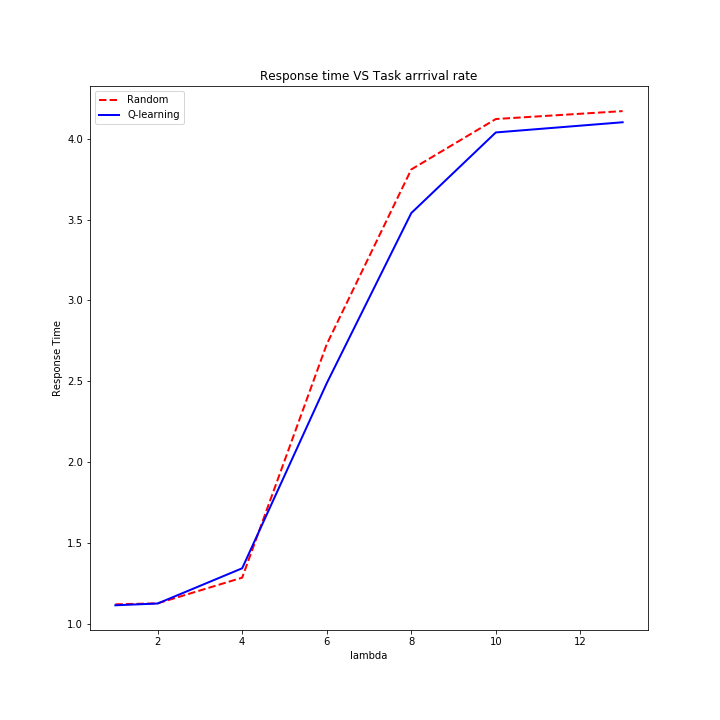

In [ ]:
Image('G:/THESIS/Figuress/c5fig1.png')

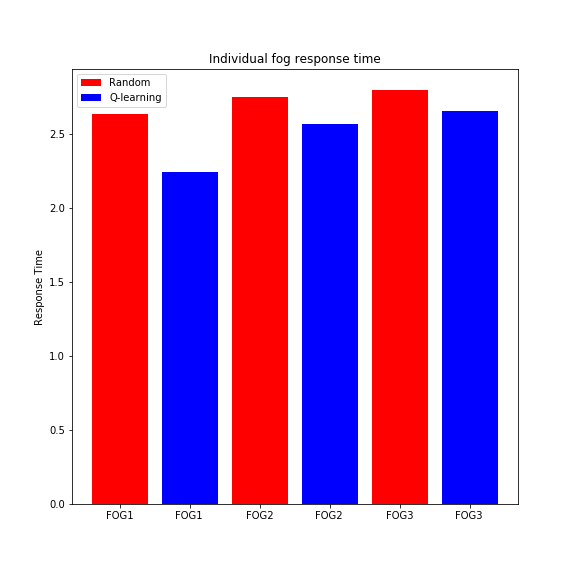

In [ ]:
Image('G:/THESIS/Figuress/c5l6fig2.png')

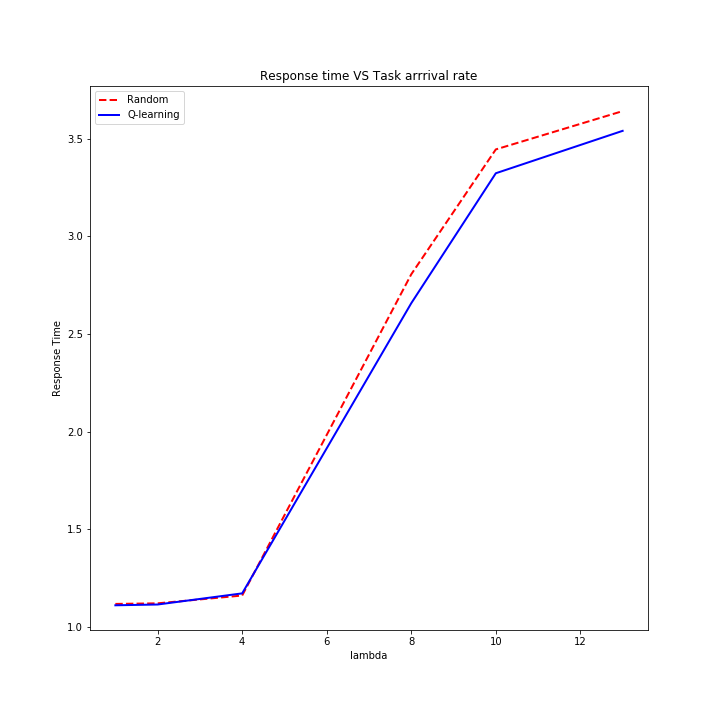

In [ ]:
Image('G:/THESIS/Figuress/c6fig1.png')


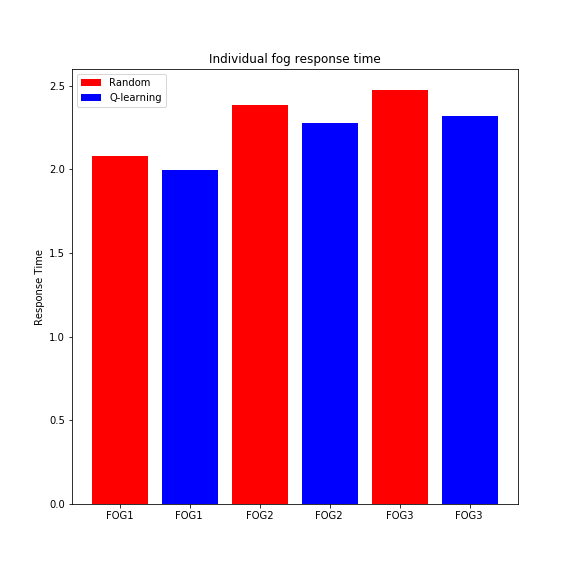

In [ ]:
Image('G:/THESIS/Figuress/c6l7fig2.png')

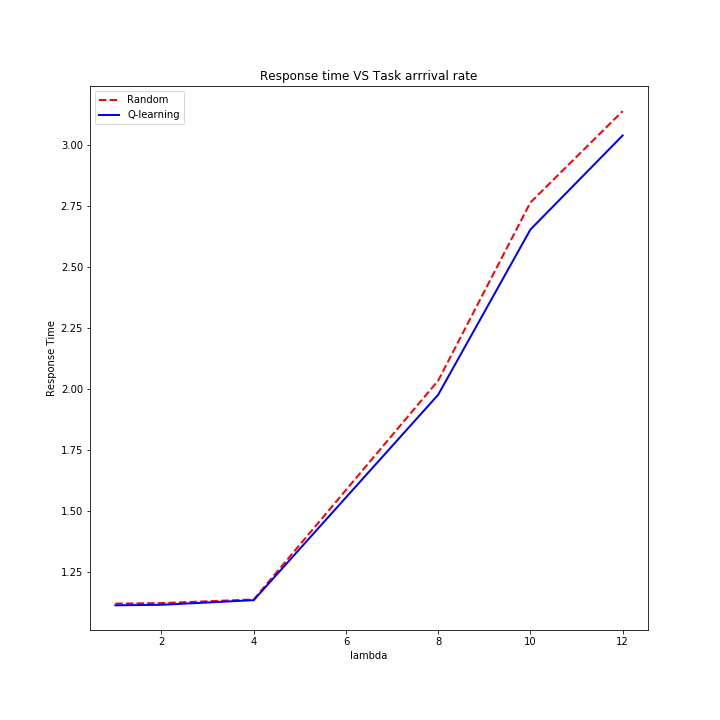

In [ ]:
Image('G:/THESIS/Figuress/c7fig1.png')

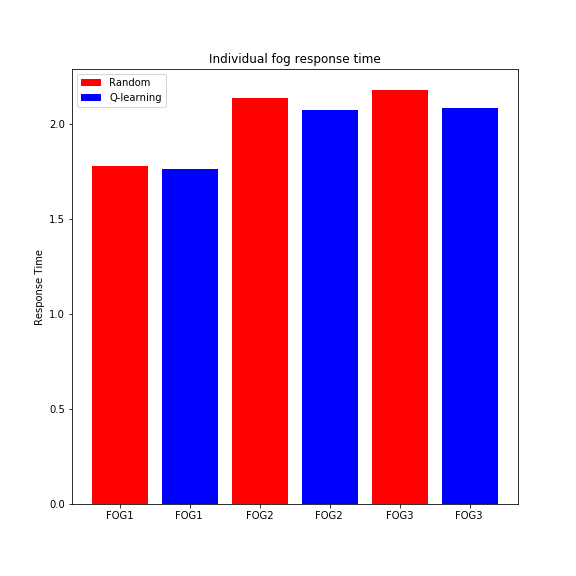

In [ ]:
Image('G:/THESIS/Figuress/c7l8fig2.png')

In [ ]:
env1 = simpy.Environment()    
server1 = simpy.Resource(env1, capacity=5)
server2 = simpy.Resource(env1, capacity=5)
server3 = simpy.Resource(env1, capacity=5)
rd.seed(2)

pipe1 = simpy.Store(env1)
pipe2 = simpy.Store(env1)
pipe3 = simpy.Store(env1)
pipe4 = simpy.Store(env1)
pipe5 = simpy.Store(env1)
statepipe = simpy.Store(env1)
currentpipe = simpy.Store(env1)

ms1=mobile(1)
ms2=mobile(2)
ms3=mobile(3)
ms4=mobile(4)

fog1 = Fog(0)
fog2 = Fog(1)
fog3=Fog(2)

fog1.Neighbour(fog2,fog3)
fog2.Neighbour(fog1,fog3)
fog3.Neighbour(fog1,fog2)


obj=Decision(1)
for i in range(N):
    env1.process(obj.decision1(env1,10,server1,server2,server3,pipe1,pipe2,pipe3,pipe4,pipe5,ms1,ms2,ms3,ms4,fog1,fog2,fog3,i,statepipe,currentpipe))
env1.run()

#print("after simulation q_table",q_table)
#print("after simulation present state and action",action_list)

fog1_count=obj.fog1_count
fog2_count=obj.fog2_count
fog3_count=obj.fog3_count
fog1_count=fog1_count-fog1.lost
fog2_count=fog2_count-fog2.lost
fog3_count=fog3_count-fog3.lost

print("lost",fog1.lost,fog2.lost,fog3.lost)
print("present count",fog1_count,fog2_count,fog3_count)
avgwaittime=sum(fog1.waitlist)/fog1_count
print("FOG-1 Average queueing time:", avgwaittime)
avgservicetime=sum(fog1.service_time)/fog1_count
print("FOG-1 Average service time:", avgservicetime)
avgsystemtime11=sum(fog1.response_time_list)/fog1_count
print("FOG-1 Average response time:", avgsystemtime)
avgenergy11=sum(fog1.energy_offloading)/fog1_count
print("FOG-1 Average Energy consumption:", avgenergy)
#print("No    response_time       reward")
#i=0
#while (i<N):
#   print("{}     {}     {}".format(i+1,fog2.response_time_list[i],fog2.reward_list[i]))
#  i+=1
#print("FOG-2 MAXIMUM REAWARD:", max(fog2.reward_list))
#print("FOG-2 total number of task in queue",fog2.Number_queue)
avgwaittime=sum(fog2.waitlist)/fog2_count
print("FOG-2 Average queueing time:", avgwaittime)
avgservicetime=sum(fog2.service_time)/fog2_count
print("FOG-2 Average service time:", avgservicetime)
avgsystemtime22=sum(fog2.response_time_list)/fog2_count
print("FOG-2 Average response time:", avgsystemtime)
avgenergy22=sum(fog2.energy_offloading)/fog2_count
print("FOG-2 Average Energy consumption:", avgenergy)

avgwaittime=sum(fog3.waitlist)/fog3_count
print("FOG-3 Average queueing time:", avgwaittime)
avgservicetime=sum(fog3.service_time)/fog3_count
print("FOG-3 Average service time:", avgservicetime)
avgsystemtime33=sum(fog3.response_time_list)/fog3_count
print("FOG-3 Average response time:", avgsystemtime)
avgenergy33=sum(fog3.energy_offloading)/fog3_count




TypeError: decision1() missing 4 required positional arguments: 'fog3', 'i', 'statepipe', and 'currentpipe'